In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import pickle
from math import cos, pi

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import read_preprocess
from models import DNN, dataset_csv

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# os.system("tshark -r /home/user/Sarvesh/Baap_Product/AutoML_DL/security/ISCX_Botnet-Training.pcap -T fields -e ip.src -e frame.len -e     ip.proto -E separator=, -E occurrence=f > /home/user/Sarvesh/Baap_Product/AutoML_DL/security/ISCX_Botnet-Training.csv")

In [ ]:
frame = pd.read_csv('./CICIDS2017/combined_data_train.csv', index_col=False)
frame['Label'].value_counts()

In [ ]:
target = 'Label'
y = frame[target]
X = frame.loc[:, frame.columns != target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train)

pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,40,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [ ]:
pca_transformer = PCA(n_components=35)
pca = pca_transformer.fit_transform(X_std)

clf = RandomForestClassifier(max_depth=5, n_jobs=-1,random_state=0)
clf.fit(pca, y_train)

In [ ]:
y_train

Training Dataset: x: (1809840, 78), y: (1809840, 8)                
 Validation Dataset: x: (452460, 78), y: (452460, 8)


Text(0, 0.5, 'Cumulative explained variance')

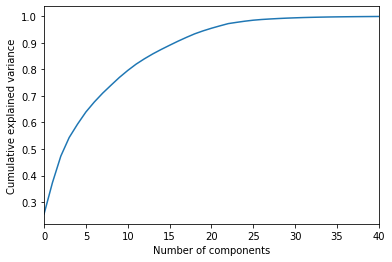

In [4]:
file_path = './CICIDS2017/combined_data_train.csv'
target = 'Label'
split = 0.2
x_train, x_val, y_train, y_val, tgt_type = read_preprocess.read_and_preprocess(file_path, target, split)

pca = PCA().fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,40,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [5]:
pca_transformer = PCA(n_components=35)
pca = pca_transformer.fit_transform(x_train)

In [8]:
x_train = torch.from_numpy(pca).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).long())

pca_val = pca_transformer.transform(x_val)
x_val = torch.from_numpy(pca_val).float()
y_val = torch.squeeze(torch.from_numpy(y_val.to_numpy()).long())

In [9]:
def cosine_lr(lr, epoch, step_size):
    lr = lr/2 * (cos(pi*(epoch%step_size)/step_size)+1)
    return lr

In [10]:
def train(lr, batch_size, epochs, x_train, y_train, x_val, y_val,step_size, tgt_type):
    print(y_train.shape[1])
    highest_acc = 0
    net = DNN(x_train.shape[1], tgt_type, [128,128,64,32],y_train.shape[1])
    
    if tgt_type=="regression":
        criterion = nn.MSELoss()
    else:
        criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    params = {
        'batch_size': 64,
        'shuffle': True,
        'num_workers': 0
    }
    training_set = dataset_csv(x_train, y_train)
    train_loader = DataLoader(training_set, **params)
    validation_set = dataset_csv(x_val, y_val)
    val_loader = DataLoader(validation_set, **params)
    
    
    net = net.to(device)
    criterion = criterion.to(device)
    
    for epoch in range(epochs):
        for a in optimizer.param_groups:
            lr = cosine_lr(lr, epoch, step_size) + 1e-5
            a['lr'] = lr
        t_loss, a, acc = 0, 0, 0
        log = {'y_train': [], 'y_val': [], 'y_pred': [], 'y_val_pred': []}
        for x_train, y_train in train_loader:
            a+=1
            x_train, y_train = x_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            net.train()
            y_pred = net(x_train)
            train_loss = criterion(y_pred, torch.max(y_train, 1)[1])
            t_loss += train_loss
            train_loss.backward()
            optimizer.step()
            acc += (y_pred.argmax(dim=1) == torch.max(y_train, 1)[1]).sum().float() / float(y_train.size(0))
        print(acc/a)
        t_loss /= a
        if epoch%1 == 0:
            with torch.set_grad_enabled(False):
                test_loss, a, acc = 0, 0, 0
                for x_val, y_val in val_loader:
                    a += 1
                    x_val, y_val = x_val.to(device),y_val.to(device)
                    y_test_pred = net(x_val)
                    y_test_pred = torch.squeeze(y_test_pred)
                    test_loss += criterion(y_test_pred, torch.max(y_val, 1)[1])
                    acc += (y_test_pred.argmax(dim=1) == torch.max(y_val, 1)[1]).sum().float() / float(y_val.size(0))
            if (acc/a)>highest_acc: 
                highest_acc = acc/a
                torch.save(net.state_dict(),"./model_info/14_may_1.pth")
            print(acc/a)
            test_loss /= a
            print(f'[epoch]: {epoch}, [Train Loss]: {t_loss.item()}, [Val Loss]: {test_loss.item()}')
        
        if tgt_type=="regression":
            if epoch%30==0:
                scaler_t = pickle.load(open('./model_info/scaler_t.pkl','rb'))
                y_0 = scaler_t.inverse_transform(log['y_train'])
                y_1 = scaler_t.inverse_transform(log['y_pred'])
                rmse = np.sqrt(mean_squared_error(y_0,y_1))
                print(rmse)
                y_0 = scaler_t.inverse_transform(log['y_val'])
                y_1 = scaler_t.inverse_transform(log['y_val_pred'])
                rmse = np.sqrt(mean_squared_error(y_0,y_1))
                print(rmse)
    return net, log

In [12]:
trained_model, log = train(0.01, 256, 100, x_train, y_train, x_val, y_val, 10, tgt_type)

8
tensor(0.9486, device='cuda:0')
tensor(0.9558, device='cuda:0')
[epoch]: 0, [Train Loss]: 0.15064316987991333, [Val Loss]: 0.1431724578142166
tensor(0.9427, device='cuda:0')
tensor(0.9144, device='cuda:0')
[epoch]: 1, [Train Loss]: 0.16550908982753754, [Val Loss]: 0.2025207132101059
tensor(0.9404, device='cuda:0')
tensor(0.9447, device='cuda:0')
[epoch]: 2, [Train Loss]: 0.1815788298845291, [Val Loss]: 0.17326107621192932
tensor(0.9440, device='cuda:0')
tensor(0.9454, device='cuda:0')
[epoch]: 3, [Train Loss]: 0.16274936497211456, [Val Loss]: 0.1561865210533142
tensor(0.9551, device='cuda:0')
tensor(0.9588, device='cuda:0')
[epoch]: 4, [Train Loss]: 0.13314948976039886, [Val Loss]: 0.117013119161129
tensor(0.9622, device='cuda:0')
tensor(0.9677, device='cuda:0')
[epoch]: 5, [Train Loss]: 0.11140016466379166, [Val Loss]: 0.09680399298667908
tensor(0.9685, device='cuda:0')
tensor(0.9711, device='cuda:0')
[epoch]: 6, [Train Loss]: 0.09385165572166443, [Val Loss]: 0.08940961211919785
ten

tensor(0.9827, device='cuda:0')
tensor(0.9821, device='cuda:0')
[epoch]: 57, [Train Loss]: 0.058597054332494736, [Val Loss]: 0.06042348966002464
tensor(0.9827, device='cuda:0')
tensor(0.9823, device='cuda:0')
[epoch]: 58, [Train Loss]: 0.05846099555492401, [Val Loss]: 0.06040690094232559
tensor(0.9827, device='cuda:0')
tensor(0.9822, device='cuda:0')
[epoch]: 59, [Train Loss]: 0.05837028846144676, [Val Loss]: 0.06031060963869095
tensor(0.9827, device='cuda:0')
tensor(0.9820, device='cuda:0')
[epoch]: 60, [Train Loss]: 0.058475345373153687, [Val Loss]: 0.06053091958165169
tensor(0.9826, device='cuda:0')
tensor(0.9823, device='cuda:0')
[epoch]: 61, [Train Loss]: 0.05856046453118324, [Val Loss]: 0.06054621934890747
tensor(0.9826, device='cuda:0')
tensor(0.9821, device='cuda:0')
[epoch]: 62, [Train Loss]: 0.05859262868762016, [Val Loss]: 0.06002188101410866
tensor(0.9826, device='cuda:0')
tensor(0.9823, device='cuda:0')
[epoch]: 63, [Train Loss]: 0.05846094340085983, [Val Loss]: 0.06006117

In [ ]:
# file_path = './upvotes/train.csv'
# target = 'Upvotes'

# X,y = read_and_preprocess_test(file_path, target, tgt_type)
ckpt_dir = "./model_info/14_may_1.pth"
def test(X,y, tgt_type, ckpt_dir):
    trained_model = DNN(x_train.shape[1], tgt_type, [128,128,64,32],y_train.shape[1])
    trained_model.load_state_dict(torch.load(ckpt_dir))
    trained_model
    x_test = X
    if y is not None:
        y_test = y
    trained_model.eval()
    y_pred = trained_model(x_test)
    y_pred = torch.squeeze(y_pred)
    return y_pred

In [ ]:
predictions = test(x_val,y_val,tgt_type,ckpt_dir)
enc = pickle.load(open('./model_info/OHE.pkl','rb'))
df = pd.DataFrame(columns=['gt','predictions'])
# df[['predictions']] = scaler_t.inverse_transform(df[['predictions']])

In [ ]:
gt = torch.max(y_val, 1)[1].detach().numpy()
df = pd.DataFrame(gt)
df

In [ ]:
df = pd.DataFrame(columns=['gt','predictions'])
df['gt'] = gt
df['predictions'] = predictions.argmax(dim=1)
pred_df = pd.DataFrame(classification_report(df['gt'], df['predictions'], output_dict=True))
pred_df

In [ ]:
cm = pd.DataFrame(confusion_matrix(df['gt'], df['predictions']))
cm

In [ ]:
file_path = './CICIDS2017/combined_data_test.csv'
target = 'Label'
x_test, y_test = read_preprocess.read_and_preprocess_test(file_path, target, split)

x_test = torch.from_numpy(x_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).long())

In [ ]:
predictions = test(x_test,y_test,tgt_type,ckpt_dir)
enc = pickle.load(open('./model_info/OHE.pkl','rb'))
df = pd.DataFrame(columns=['gt','predictions'])
gt = torch.max(y_test, 1)[1].detach().numpy()
df = pd.DataFrame(gt)
df = pd.DataFrame(columns=['gt','predictions'])
df['gt'] = gt
df['predictions'] = predictions.argmax(dim=1)
pred_df = pd.DataFrame(classification_report(df['gt'], df['predictions'], output_dict=True))
pred_df, pd.DataFrame(confusion_matrix(df['gt'], df['predictions']))

In [ ]:
pred.numpy()

In [ ]:
b = np.zeros((gt.size, gt.max()+1))
b[np.arange(gt.size),gt] = 1
gt2 = b

pred = predictions.argmax(dim=1).numpy()
b = np.zeros((pred.size,pred.max()+1))
b[np.arange(pred.size),pred] = 1
pred = b

In [ ]:
enc.inverse_transform(gt2)

In [ ]:
df['gt'] = enc.inverse_transform(gt2)
df['predictions'] = enc.inverse_transform(pred)
pred_df = pd.DataFrame(classification_report(df['gt'], df['predictions'], output_dict=True))
pred_df

In [ ]:
labels = df['gt'].unique().tolist()

In [ ]:
pd.DataFrame(confusion_matrix(df['gt'], df['predictions'],normalize = 'all'), index = labels,columns = labels)